# Library import

In [ ]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib.pyplot as plt

import string

import re
from wordcloud import WordCloud
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn import metrics

from P6_function import *

plt.rcParams['figure.figsize'] = (12, 8)
#plt.rcParams['figure.dpi'] = 100

pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 50)

# Data loading

In [ ]:
# Load in the dataframe
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

# Looking at first 5 rows of the dataset
df.head()

In [ ]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

In [ ]:
df.info()

In [ ]:
for column in df.columns:
    if df[column].nunique() < 20:
        print('Column {}, unique value :\n{}\n'.format(column, df[column].unique()))
    else:
        print('Column {}, {} unique value'.format(column, df[column].nunique()))

In this dataset we will be interest in a few features:
 - uniq_id which is the primary key of the dataset
 - product_category_tree which is the potentiel true category for each product
 - image allow us to link each image to the id and the product category
 - description is the feature which will be used for NLP analysis 

# Feature cleaning

## product_category_tree

The purpose here is to select at which step of the category tree we can find a relevant information to categorise product. 
The steps should be without missing value, suffisantly different but not too specific.

In [ ]:
# Visualisation of product category tree structure
df.product_category_tree.head()

In [ ]:
# Creation of a function to clean product cat tree

def clean_cat(text):
    # Remove unneeded character
    text = re.sub(r'\["', repl='', string=text)
    text = re.sub(r'\"]', repl='', string=text)
    text = re.sub(' +', ' ', text)
    # Lower case to avoid spelling differences
    text = text.lower()
    return text
cat = df.product_category_tree.apply(lambda txt : clean_cat(txt))

# Expand the serie into a dataframe
df_cat = pd.DataFrame(cat.str.split('>>', expand = True))

# Replace None value by NaN
df_cat.replace(to_replace=[None], value=np.nan, inplace=True)
df_cat.head(10)


In [ ]:
# Check the unique value for each category tree step
for column in range(0, 7):
    if df_cat.iloc[:, column].nunique() < 20:
        print('Column {}, unique value :\n{}\n'.format(column, df_cat.iloc[:, column].unique()))
    else:
        print('Column {}, {} unique value'.format(column, df_cat.iloc[:, column].nunique()))

In [ ]:
# Check missing value per step
filling_factor(df_cat).sort_values(by = 'column_name')

In [ ]:
for col in range(0,2):
    barchart_percent(x = col,
    data=df_cat,
    rotation = True)

The first step of the category tree seems to fit for our puropse: 
- No missing value
- Not to specific
- Equally distributed into 7 categories

In [ ]:
# Cleand and create new features with the category tree feature

def clean_cat(text):
    # Remove unneeded character
    text = re.sub(r'\["', repl='', string=text)
    text = re.sub(r'\"]', repl='', string=text)
    text = re.sub(' +', ' ', text)
    # Lower case to avoid spelling differences
    text = text.lower()
    #text = text.split(' >> ')
    return text

df.product_category_tree = df.product_category_tree.apply(lambda txt : clean_cat(txt))

# Expand the serie into a dataframe
df['product_category'] = df.product_category_tree.str.split(' >> ', expand = True, n=2).iloc[:, :-2]

df.head()

In [ ]:
# Encoding product category with LabelEncoder
le = LabelEncoder()

# Create a label feature
df['label'] = le.fit_transform(df['product_category'])


## Keep feature of interest

In [ ]:
df.columns

In [ ]:
# Keep features need for the clusering NLP clustering trials
features = ['uniq_id',
            'image',
            'description',
            'product_category',
            'label']

df = df[features]
df.head()

## Description cleaning

I will first clean the description using NLP technique : tokennisation, lemmanization, remove stopwords...

In [ ]:
# Function to clean each description
def clean_text(text):
    # Convert all character to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'(?<=[.,])(?=[^\s])', r' ', text)
    text = ''.join([word for word in text if word not in string.punctuation])
    

    # Remove URL
    text = re.sub(r'http.+?(?="|<)',
                  repl='',
                  string=text)

    # Remove digits
    text = ''.join([word for word in text if word not in string.digits])

    # Remove withespace
    text = re.sub(' +', ' ', text)

    return text

In [ ]:
# Visusalisation of text cleaning
df.loc[:, 'processed_description'] = df.loc[:, 'description'].apply(lambda txt : clean_text(txt))
df['processed_description'].head(10)

The process of transforming a text into a list of words is called **tokenization**, and words are called tokens. In other words, tokenization chops up a text into pieces called tokens. 

**Lemmatization** is the process of reducing multiple variants of a word to its unique lemma. It is more readable and interpretable and less brutal than stemming. It is also slower.

In [ ]:
df['processed_description'][0]

In [ ]:
# Create a function to lemmatize each description
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    # Tokenize each description
    doc = nlp(text)
    # Lemmanize each token
    tokens = [token.lemma_ for token in doc] 
    return ' '.join(tokens)

df.loc[:, 'processed_description'] = df.loc[:, 'processed_description'].apply(lambda txt : lemmatize(txt))
df.loc[:, 'processed_description'].head(10)

**Stop words** are words that do not provide any useful information to infer content or nature. It may be either because they don't carry any meaning (prepositions, conjunctions, etc.) or because they are too frequent.

In [ ]:
# Removing Stop Word from nltk stopword list
stop_words = set(stopwords.words("english"))

def remove_stopwords(text: str, stop_words: list):
    words = [word for word in text.split() if word.lower() not in stop_words]

    return ' '.join(words)

df.processed_description = df.processed_description.apply(lambda x: remove_stopwords(x, stop_words))

In [ ]:
# Visually check if their is no other stop word to add with a wordcloud

from wordcloud import WordCloud

long_string = ','.join(df.loc[:, 'processed_description'].values)
wordcloud = WordCloud(background_color="white",
                      max_words=200,
                      contour_width=3,
                      width=1000,
                      height=1000,
                      contour_color='steelblue')
wordcloud.generate(long_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can find words which don't have any specific value in our context as cash, delivery ect..

In [ ]:
# Creating a list of custom stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

new_words =  ['product', 'free', 'cm', 'buy', 'delivery',
              'shipping', 'genuine', 'cash', 'price', 'replacement',
              'day', 'flipkart', 'guarantee', 'feature', 
              'online', 'specification', 'color', 'type', 'material',
              'general', 'number', 'brand', 'best', 'key', 'size',
              'dimension', 'sale', 'discount', 'pack', 'package', 'box',
              'rs', 'india', 'great', 'gift', 'abstract', 'ideal', 'love', 'one', 'design', 'set', 
             'com', 'ship']

stop_words = stop_words.union(new_words)

# Remove customed stopwords
df.loc[:, 'processed_description'] = df.loc[:, 'processed_description'].apply(lambda x: remove_stopwords(x, stop_words))

In [ ]:
# Visualy check stopword removing
long_string = ','.join(df.loc[:, 'processed_description'].values)
wordcloud = WordCloud(background_color="white",
                      max_words=200,
                      contour_width=3,
                      width=1000,
                      height=1000,
                      contour_color='steelblue')
wordcloud.generate(long_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
df.processed_description[10]

# Product clustering with NLP features

The objectif of the project is to : 
    conduct a first feasibility study of an article classification engine based on an **image** and **description** for automating the assignment of the article category

Here we focus on description clustering

I will use the unsupervised k-means algorithm to find out the best number of cluster using the description of each product prepocessed as Bag Of Word. 
I keep in mind that during the data exploration we find out that product were uniformly distribut into 7 categories (home furnishing, baby care, watches, home decor & festive needs, kitchen & dining, beauty and personal care and computers). So then we know a certain 'true label' for each product.

So the study process will be the following :
- I will first try to find out if 7 clusters is a good amount a cluster using unspervised kmean clustering and elbow method, silouhette score and intercluster distance as validation metrics.
- If 7 clusters seems to be a resonnable amount of cluster I will then try to find the best way of preprocessing for the description. I will compare Count Vectorisation with and without Tfidf, check if the use bigram and trigram is relevant to have a best cluster and define the minimum amount of frequency for each word use. 

To find out the best preprocessing for clustering I will use the ARI with the 'true label' being the product category and the predicted label the cluster create with kmean over a different type of preprocessing.

## N-gram analysis

Some words are better understood together. For instance, deep learning, New York, love at first sight, or The New England Journal of Medicine. Therefore, when tokenizing a text, it can be useful to consider groups of two words (bigrams) or three words (trigrams), etc. In general, groups of words taken as a single token are called n-grams.

In [ ]:
# Plot the 10 most represented nGram with CountVectorizer and Tfidf Vectorisation

plot_n_gramms(data=df['processed_description'],
              use_tfidf=False,
              ngram_ranges=[(1,1),(2,2),(3,3)],
              titles=['BoW Unigram', 'BoW Bigram', 'BoW Trigram'])

plot_n_gramms(data=df['processed_description'],
              use_tfidf=True,
              ngram_ranges=[(1,1),(2,2),(3,3)],
              titles=['BoW+Tfidf Unigram', 'BoW+Tfidf Bigram', 'BoW+Tfidf Trigram'])

## Unsupervised Kmeans clustering

In [ ]:
# Vectorisation
vectorizer = TfidfVectorizer(ngram_range=(1,1),
                             min_df=.01)

X_vec = vectorizer.fit_transform(df.processed_description)
X_vec.shape

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

I will keep the minimum number of component which explained 99% of the variance of the features

In [ ]:
def best_n_components(X):
    '''
    Find the number of component for LSA which explain
    99 % of the variance
    '''
    
    svd = TruncatedSVD(n_components = np.min(X.shape) - 1)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X_reduced = lsa.fit_transform(X)
    
    best_n_component = np.argmax(np.cumsum(svd.explained_variance_ratio_) > 0.99)

    plt.plot(np.cumsum(svd.explained_variance_ratio_)) 
    plt.hlines(y=.99, xmin=0, xmax=np.min(X.shape) - 1, color='red')
    plt.xlabel('Number of components')
    plt.ylabel('Percent of variance explained')
    plt.show()

    
    print('The best component number is: ', best_n_component)

    return best_n_component

In [ ]:
# Find the n component which can explain 99% of the variance of the dataset 
best_n = best_n_components(X=X_vec)


In [ ]:
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.

svd = TruncatedSVD(n_components=best_n)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_reduced = lsa.fit_transform(X_vec)

In [ ]:
# Model evaluation
model = KMeans(max_iter=1000,
               n_init=10,
               random_state=123)

# Use the elbow methods to find the best number of cluster
elbow_eval(X=X_reduced, model=model, k_min=2, k_max=12)

In [ ]:
# Evaluation using silouhette score and Intercluster Distance Map
silouhette_eval(X=X_reduced, k_min=5, k_max=10)

7 clusters seems to be a good choice a number of clusters. We can then compare with the product 'true label' and try to find the best vectorisation parameter.

## Evaluation of vectorizer best parameter for 7 clusters

Vectorization is the general process of turning a collection of text documents (a corpus) into numerical feature vectors fed to machine learning algorithms for modeling.
When you vectorize the corpus, you convert each word or token from the documents into an array of numbers. This array is the vector representation of the word.

**Bag-of-words (BOW)** is a simple but powerful approach to vectorizing text.

As the name may suggest, the bag-of-words technique does not consider the position of a word in a document. The idea is to count the number of times each word appears in each of the documents. This approach may sound silly and crude since, without proper word order, humans would not understand the text at all. That's the beauty of the bag-of-words system: it is simple, but it works.

The problem with counting word occurrences is that some words appear only in a limited number of documents. The model will learn that pattern, overfit the training data, and fail to generalize to new texts properly. Similarly, words that are present in all the documents will not bring any information to the classification model.

For this reason, it is sometimes better to normalize the word counts by the number of times they appear in the documents. This is the general idea behind the tf-idf vectorization.

   **Tf** stands for **term frequency**, the number of times the word appears in each document.

   **Idf** stands for **inverse document frequency**, an inverse count of the number of documents a word appears in. Idf measures how significant a word is in the whole corpus.

ARI score is calculated with the product categrory features as the true label and the create cluster as the predict value. 

In [ ]:
# First we create list of vectorised description for each type paramater. 

model = KMeans(n_clusters=7,
               max_iter=1000,
               n_init=10,
               random_state=123)

for vec in [CountVectorizer, TfidfVectorizer]:
    print(f'------{vec}-------')
    print(f'------unigram-------')
    bows, vectorizers = vectorized_ngrams(data=df.processed_description,
                                          vec=vec,
                                          min_words=list(range(10, 160, 10)),
                                          ngram=(1, 1),
                                          print_res=True)
    print(f'------bigram-------')
    bows_bi, vectorizers = vectorized_ngrams(data=df.processed_description,
                                        vec=vec,
                                        min_words=list(range(10, 100, 10)),
                                        ngram=(2, 2),
                                        print_res=True)
    print(f'------trigram-------')
    bows_tri, vectorizers = vectorized_ngrams(data=df.processed_description,
                                        vec=vec,
                                        min_words=list(range(10, 50, 10)),
                                        ngram=(3, 3),
                                        print_res=True)
    print(f'------uni + bigram-------')
    bows_uni_bi, vectorizers = vectorized_ngrams(data=df.processed_description,
                                        vec=vec,
                                        min_words=list(range(10, 160, 10)),
                                        ngram=(1, 2),
                                        print_res=True)
    print(f'------uni + bi + trigram-------')
    bows_uni_tri, vectorizers = vectorized_ngrams(data=df.processed_description,
                                        vec=vec,
                                        min_words=list(range(10, 160, 10)),
                                        ngram=(1, 3),
                                        print_res=True)
    
    x_range = list(range(0, 160, 10))
    
    if vec == TfidfVectorizer:
        tfidf = True
    else:
        tfidf = False

    plot_all_aris_score(vectorized_values_list=[bows, bows_bi, bows_tri, bows_uni_bi, bows_uni_tri],
                        true_labels=df.product_category,
                        tfidf=tfidf,
                        x_value=x_range,
                        metric='ARI',
                        model=model, 
                        legends= ['Unigram', 'Bigram', 'Trigram', 'Uni+bigram', 'Uni+bi+trigram'])

The best vectorisation parameter are Tfidf vectorizer, using unigram only for a minimal occurancy of 20. For those parameter the best n features for dimension reduction is 163.

The ARI score for this clustering is 0.339

## Kmean clustering (7 clusters) using vectorisation best parameter

In [ ]:
# We use the best parameter define previously
vectorizer = TfidfVectorizer(ngram_range=(1,1),
                             min_df=20)
X_vec = vectorizer.fit_transform(df.processed_description)


In [ ]:
# Find the n component which can explain 99% of the variance of the dataset 
best_n = best_n_components(X=X_vec)

In [ ]:
# Fitting kmeans model
svd = TruncatedSVD(n_components=163)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_reduced = lsa.fit_transform(X_vec)
X_reduced.shape

model = KMeans(n_clusters=7,
               max_iter=1000,
               n_init=10,
               random_state=123)


model.fit(X_reduced)

## 2D visualisation of clustering and product category

* Categroies seems not separate
* However cluster seems 'well' separate 

In [ ]:
def two_dim_viz(X):
    # Create 2D TSNE
    X_tsne = TSNE(n_components=2,
                  init='random',
                  learning_rate='auto',
                  perplexity=np.sqrt(X_reduced.shape[0]),
                  n_iter=1000,
                  random_state=123).fit_transform(X)

    # Plot creation
    plt.figure(figsize=(12, 8))

    sns.scatterplot(x=X_tsne[:, 0],
                    y=X_tsne[:, 1],
                    hue=cluster_labels,
                    legend="brief",
                    s=100,
                    alpha=.5,
                    palette='Set1'
                    )
    plt.xlabel("tsne1")
    plt.ylabel("tsne2")
    plt.title("t-SNE clusters representation")
    plt.legend()
    plt.show()

In [ ]:
# Show visualisation with dimension reduction for product category

print('Visualisation of product category repartition')
cluster_labels = df.loc[:, 'product_category']
two_dim_viz(X=X_reduced)

print('\n\n')

print('Visualisation of clustering')
cluster_labels = model.labels_
two_dim_viz(X=X_reduced)

## Cluster analysis
- we first check the first 5 most represented word for each cluster

- Then we compare with a confusion matrix and accuracy clsuters and actual product category
    * Confusion matrix should be transform to have in column the same order for cluster as for line
    * We use argmax method to transform tje confusion matrix to match cluster labels

In [ ]:
# We create a recovered dataframe to have actual token
X_recovered = svd.inverse_transform(X_reduced)

In [ ]:
# Check which word is use for evry cluster
best_df = pd.DataFrame(data = X_recovered, columns=vectorizer.get_feature_names_out())
best_df['label'] = model.labels_

plt.figure(figsize=(10, 12))
for i, label in enumerate(set(model.labels_)):
    top_5 = best_df[best_df.label == label].drop('label', axis=1).sum(axis=0).sort_values(ascending=False)[:5]
    plt.subplot(4, 2, i + 1)
    plt.barh(top_5.index, width=top_5.values)

    plt.title(f'Most represented word for the cluster {label}',
             fontsize=5)
plt.show()
plt.tight_layout()

This analysis allows use to define probable new stop word as 'SET' by exemple which is one of the most used word for 2 clusters

TO do the confusion matrix we have to encoded product category as number

In [ ]:
# Create a cluster feature
df['cluster_NLP'] = model.labels_

In [ ]:
# Check cluster repartition per label 
df.groupby('cluster_NLP').count()['label']

In [ ]:
# Confusion Matrix
labels = df['label']
conf_mat = metrics.confusion_matrix(labels, model.labels_)
print(conf_mat)

In [ ]:
# Fonction to tranform confusion matrix to pairs cluster with label
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, model.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()

# Classification report for the clustering
print(metrics.classification_report(labels, cls_labels_transform))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in df['product_category'].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f' )
plt.xlabel("cluster")
plt.ylabel('product category')
plt.show()

## Conclusion 

The clustering giving a low ARI, however the visual evaluation of the cluster repartition shows a pretty well separation of between product. Moreover cluster evzaluation give good insight, computers and watches gives perfect clusters, maybe a redefinition of inital label could give a better results. -> can try classification to confirm feasability

## Word embeddings using Word2Vec

In [ ]:
# Creation of an array containing word from description
sentences = df.processed_description.apply(lambda x: x.split())

In [ ]:
# impport Word2Vec model from gensim
from gensim.models import Word2Vec

In [ ]:
# Model creation
model = Word2Vec(sentences,
                 min_count=3, # Ignore words that appear less than this
                 vector_size=300, # The vector size is 300 
                 sg = 1,        # skipgrams
                 window=7)     # Context window for words during training

In [ ]:
model.wv.most_similar('watch')

In [ ]:
#import gensim.downloader

#wv = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(df.processed_description, model=model)
len(vectorized_docs), len(vectorized_docs[0])
vectorized_docs = np.array(vectorized_docs)

In [ ]:
# Fitting kmeans model
model = KMeans(n_clusters=7,
               max_iter=1000,
               n_init=10,
               random_state=123)

model.fit(vectorized_docs)

In [ ]:
print('Visualisation of product category repartition')
cluster_labels = df.loc[:, 'product_category']
two_dim_viz(X=vectorized_docs)
print('\n\n')
print('Visualisation of clustering')
cluster_labels = model.labels_
two_dim_viz(X=vectorized_docs)
    
labels = df['label']
print("ARI: ", metrics.adjusted_rand_score(df['label'], model.labels_))

In [ ]:
df['cluster_W2W'] = model.labels_

df.groupby("cluster_W2W").count()['label']

In [ ]:
conf_mat = metrics.confusion_matrix(labels, model.labels_)
print(conf_mat)

In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [4, 6, 5, 1, 0, 2, 3]
    print ("Cluster correspondance : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, model.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))



Word embeddings does not help to have a better clusterisation

## A first trial of classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from pprint import pprint
from time import time
import logging

In [ ]:
# Train, Test split
X_train, X_test, y_train, y_test = train_test_split(df.processed_description,
                                                    df.product_category,
                                                    test_size=.2,
                                                    random_state=5)

print(X_train.shape)
print(y_train.shape)

In [ ]:
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)

# Definition of pipeline parameters
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__min_df': (0, 5, 10, 20),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3), (1, 2), (1, 3)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2')
}

In [ ]:
# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline,
                           parameters,
                           n_jobs=-1,
                           verbose=1,
                           return_train_score=True,
                           scoring='accuracy')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
# Calculate accuracy on test set

best_model = grid_search.best_estimator_

print('accuracy', accuracy_score(best_model.predict(X_test), y_test))
print('ARI', adjusted_rand_score(best_model.predict(X_test), y_test))

In [ ]:
conf_mat = metrics.confusion_matrix(best_model.predict(X_test), y_test)
print(conf_mat)

In [ ]:
print(metrics.classification_report(best_model.predict(X_test), y_test))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in df['product_category'].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f' )
plt.xlabel("classification")
plt.ylabel('product category')
plt.show()

The accuracy score of this classification is 0.92  -> a deep modelisation with more data could give a a very performant classification model

# Product clustering with Computer Vision

## ORB

### Import DataSet

In [72]:
import os
from os import listdir

path = '/Users/franck/Documents/P6_classifiez_auto_bien_conso/data/Images/'
list_img = [file for file in listdir(path) # check if the image ends with jpg
    if (file.endswith(".jpg"))]
print(len(list_img))

list_labels = ['home furnishing', 'baby care', 'watches',
       'home decor & festive needs', 'kitchen & dining',
       'beauty and personal care', 'computers']

1050


In [73]:
df.groupby('product_category').count()['label']

product_category
baby care                     150
beauty and personal care      150
computers                     150
home decor & festive needs    150
home furnishing               150
kitchen & dining              150
watches                       150
Name: label, dtype: int64

### Show image exemple

home furnishing


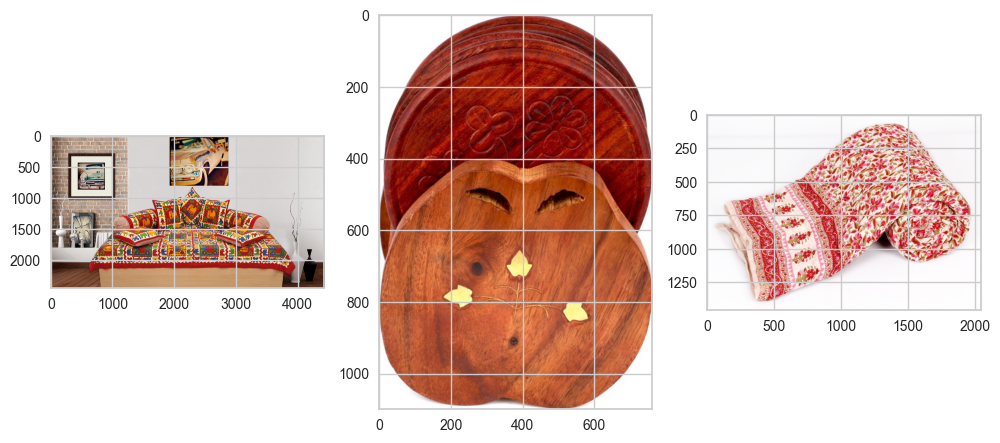

baby care


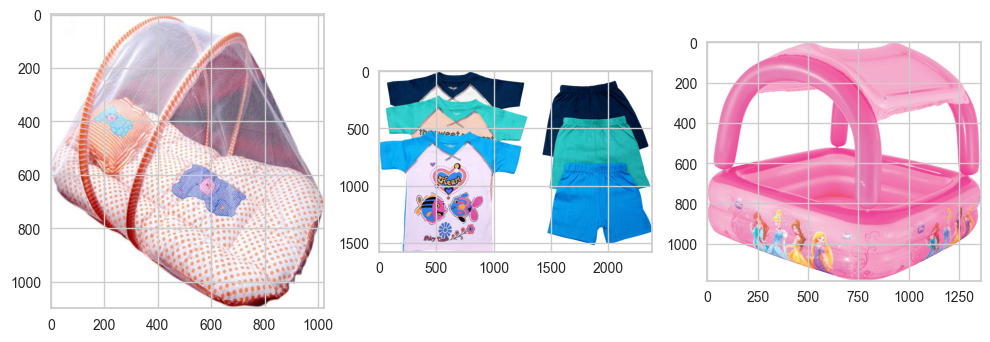

watches


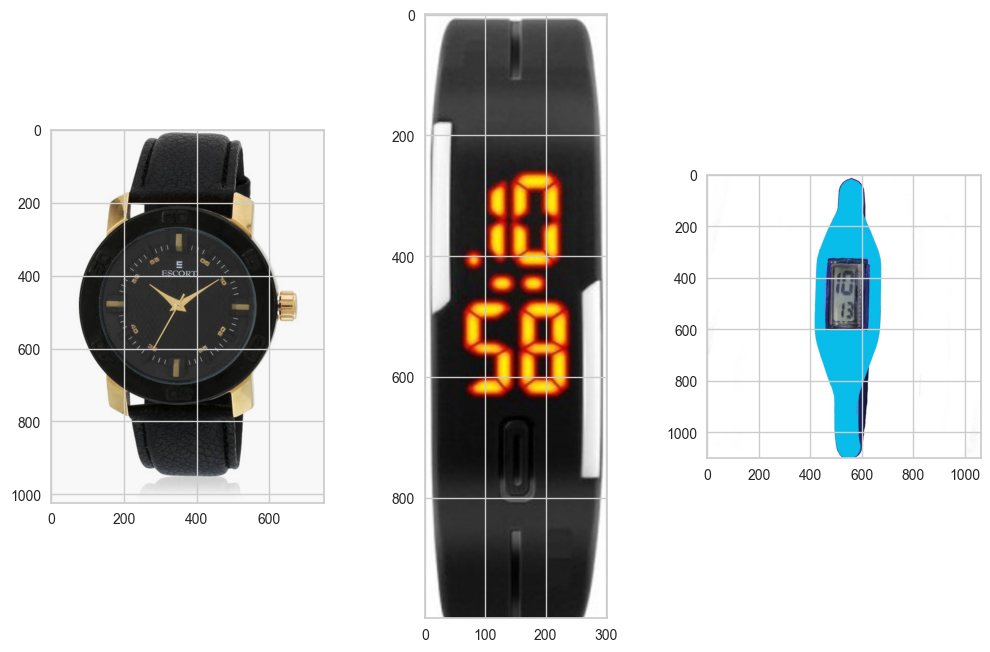

home decor & festive needs


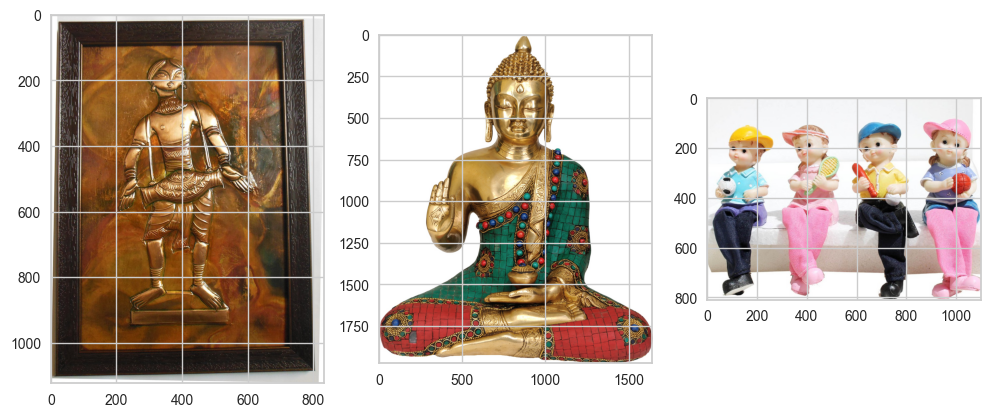

kitchen & dining


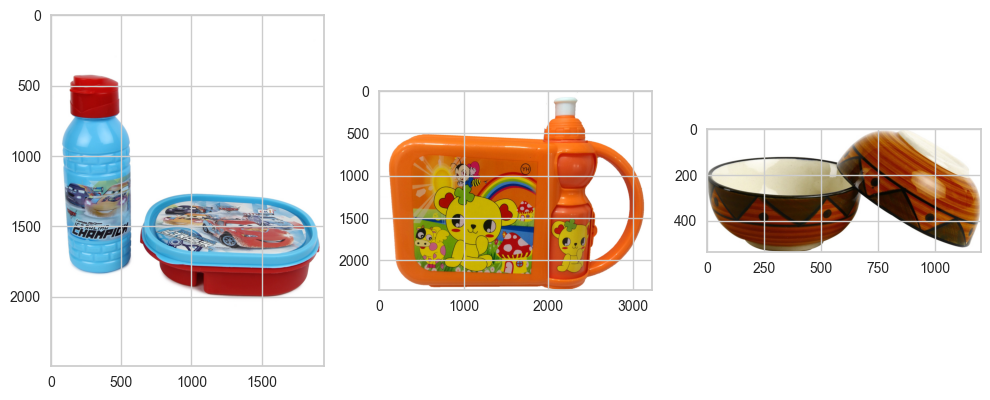

beauty and personal care


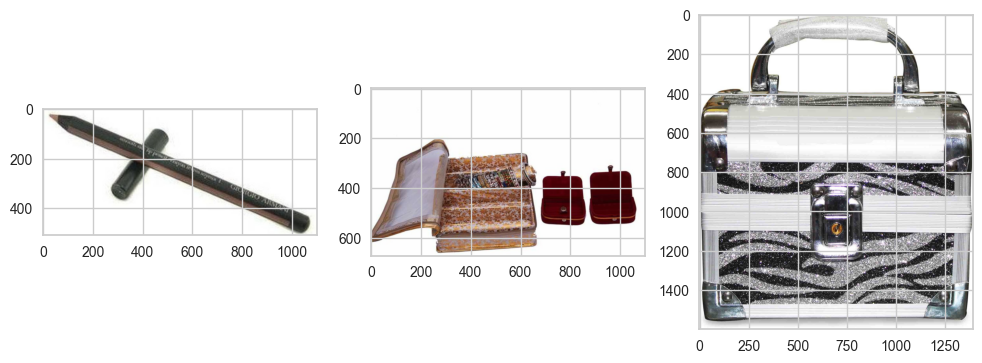

computers


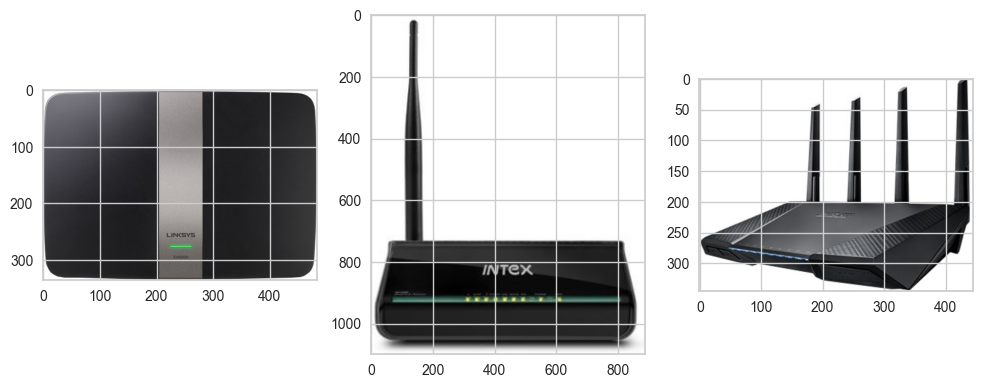

In [74]:
from matplotlib.image import imread

def list_fct(name):
    list_img_name = [df['image'][i] for i in range(len(df)) if df['product_category'][i]==name]
    return list_img_name

list_home_furnishing = list_fct('home furnishing')
list_baby_care = list_fct('baby care')
list_watches = list_fct('watches')
list_home_decor = list_fct('home decor & festive needs')
list_kitchen_dining = list_fct('kitchen & dining')
list_beauty_personal_care = list_fct('beauty and personal care')
list_computers = list_fct('computers')

for name in list_labels:
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

### Image descripter ORB


* The picture contain 500 descriptors
* Each descriptor is a vector of 32

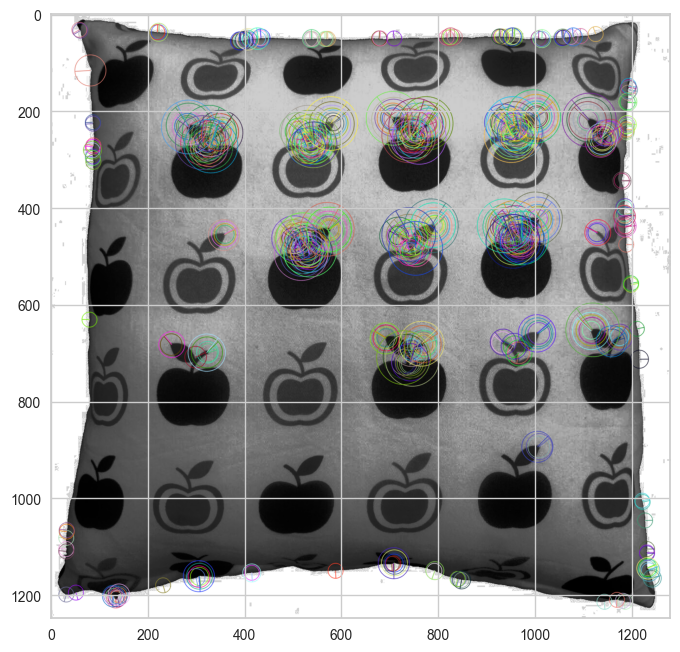

Descriptor :  (500, 32)

[[ 27 114  54 ... 140 107 215]
 [ 15  55  98 ... 207 253 245]
 [ 50   0  98 ... 140 113 213]
 ...
 [ 15 253  97 ... 182 216 245]
 [ 26 239 232 ... 220 253 222]
 [ 36 135  75 ... 139 240 128]]


In [76]:
import cv2

orb = cv2.ORB_create()
image = cv2.imread(path+list_img[100], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = orb.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()
print("Descriptor : ", des.shape)
print()
print(des)


## Creation of descriptors per image

* For each image we equalize and convert in gray
* Creation of a list of descriptors per mage ("orb_keypoints_by_img") which will be use to realise image histogramme
* Creation of liste of descriptros for all images ('orb_keypoints_all') which will be used to create desriptors clusters

In [77]:
# identification of key points and associated descriptors
import time, cv2
orb_keypoints = []
temps1 = time.time()
orb = cv2.ORB_create(500)

for image_num in range(len(list_img)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_img[image_num], 0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints, dtype="object")

orb_keypoints_all  = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nomber of descriptors : ", orb_keypoints_all.shape)

duration1 = time.time() - temps1
print("Treatment time for ORB descriptor : ", "%15.2f" % duration1, "seconds")

0
100
200
300
400
500
600
700
800
900
1000

Nomber of descriptors :  (520145, 32)
Treatment time for ORB descriptor :            75.32 seconds


### Creation of clusters of descriptors
* Use of MiniBatchKMeans to obtain a reasonnable treatment time

In [78]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Estimates number of clusters : ", k)
print("Creation of",k, "descriptors' clusters ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("kmeans treatment time: ", "%15.2f" % duration1, "seconds")

Estimates number of clusters :  721
Creation of 721 descriptors' clusters ...
kmeans treatment time:             9.19 seconds


### Creation of images features 
* For each image: 
    - predict the number of cluster for each descriptors
    - creation of histogram = count of each clusters number for each image descriptors

In [79]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0 : print("problem histogram image: ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Histogram creation time : ", "%15.2f" % duration1, "seconds")


0
100
200
300
400
500
600
700
800
900
1000
Histogram creation time :            13.93 seconds


### Dimension reduction

#### PCA dimension reduction

* PCA dimension reduction allows to create features decorreleted et decrease dimension, still with a high explained variance (99%)
* We have a better dimension reduction with T-SNE and a decrease in treatment time

In [80]:
from sklearn import manifold, decomposition

print("Dataset dimensions before PCA: ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dataset dimensions after PCA: ", feat_pca.shape)

Dataset dimensions before PCA:  (1050, 721)
Dataset dimensions after PCA:  (1050, 580)


In [81]:
# Fitting kmeans model
model = KMeans(n_clusters=7,
               max_iter=1000,
               n_init=10,
               random_state=123)

model.fit(feat_pca)

KMeans(max_iter=1000, n_clusters=7, random_state=123)

/Users/franck/opt/anaconda3/envs/P6_devenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Visualisation of product category repartition


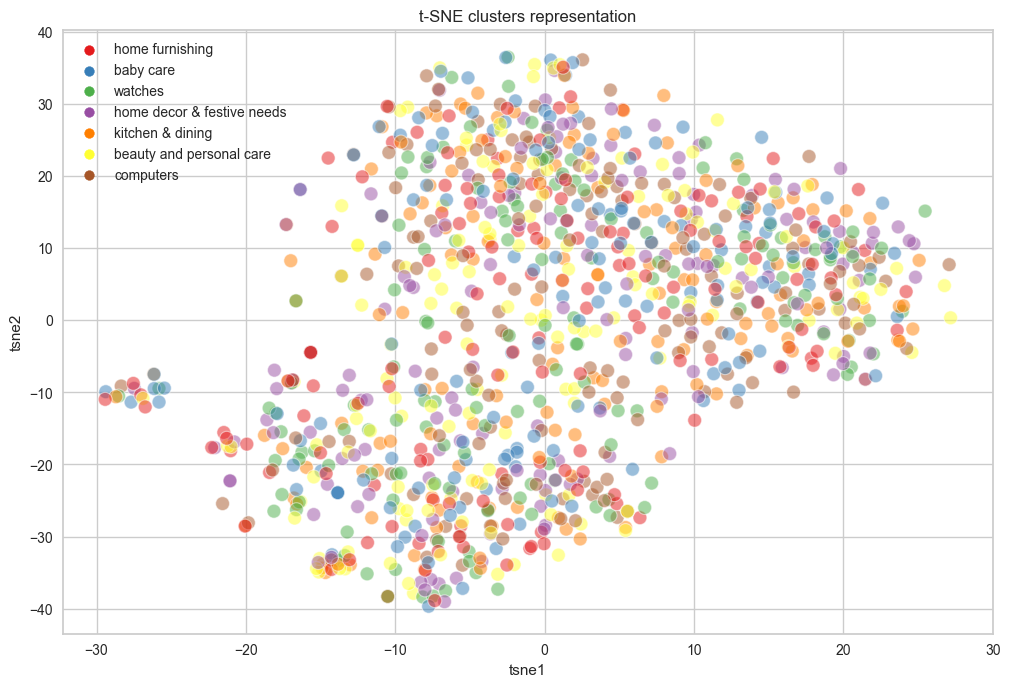




Visualisation of clustering


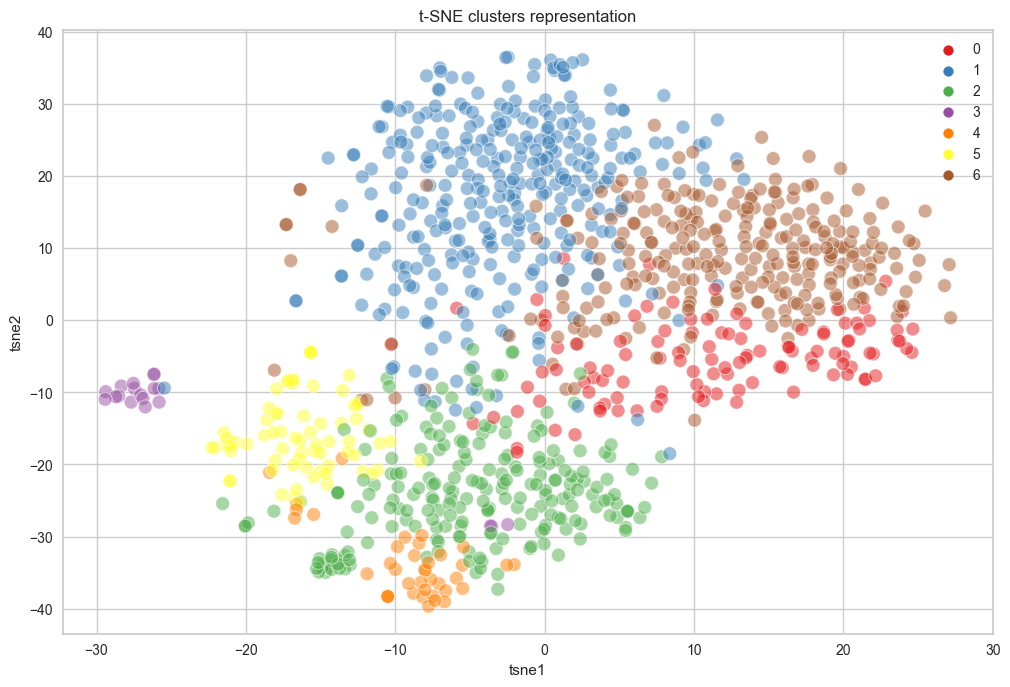

ARI:  0.00015591784332233234


In [82]:
# Show visualisation with dimension reduction for product category  

tsne = manifold.TSNE(n_components=2,
                     perplexity=30, 
                     n_iter=2000,
                     init='random',
                     random_state=123)

X_tsne = tsne.fit_transform(feat_pca)

print('Visualisation of product category repartition')
cluster_labels = df.loc[:, 'product_category']
# Plot creation
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0],
                y=X_tsne[:, 1],
                hue=cluster_labels,
                legend="brief",
                s=100,
                alpha=.5,
                palette='Set1'
                )
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.title("t-SNE clusters representation")
plt.legend()
plt.show()


print('\n\n')


print('Visualisation of clustering')
cluster_labels = model.labels_

# Plot creation
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0],
                y=X_tsne[:, 1],
                hue=cluster_labels,
                legend="brief",
                s=100,
                alpha=.5,
                palette='Set1'
                )
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.title("t-SNE clusters representation")
plt.legend()
plt.show()

labels = df['label']
print("ARI: ", metrics.adjusted_rand_score(df['label'], model.labels_))

### Cluster Analysis
* Confusion matrix should be transform to have in column the same order for cluster as for line
* We use argmax method to transform tje confusion matrix to match cluster labels

In [83]:
df['cluster_ORB'] = model.labels_

In [84]:
df.groupby("cluster_ORB").count()['label']

cluster_ORB
0    112
1    322
2    218
3     19
4     39
5     73
6    267
Name: label, dtype: int64

In [85]:
conf_mat = metrics.confusion_matrix(labels, model.labels_)
print(conf_mat)

[[14 47 27  5  5  8 44]
 [ 9 45 38  1  7  9 41]
 [21 55 33  2  2  4 33]
 [13 41 28  1  9 13 45]
 [12 44 32  5  6 15 36]
 [27 44 28  3  3 10 35]
 [16 46 32  2  7 14 33]]


In [86]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [2, 3, 0, 6, 5, 1, 4]
    print ("Cluster correspondance : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, model.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Cluster correspondance :  [2, 3, 0, 6, 5, 1, 4]
[[27  8 14 47 44  5  5]
 [38  9  9 45 41  7  1]
 [33  4 21 55 33  2  2]
 [28 13 13 41 45  9  1]
 [32 15 12 44 36  6  5]
 [28 10 27 44 35  3  3]
 [32 14 16 46 33  7  2]]

              precision    recall  f1-score   support

           0       0.12      0.18      0.15       150
           1       0.12      0.06      0.08       150
           2       0.19      0.14      0.16       150
           3       0.13      0.27      0.17       150
           4       0.13      0.24      0.17       150
           5       0.08      0.02      0.03       150
           6       0.11      0.01      0.02       150

    accuracy                           0.13      1050
   macro avg       0.13      0.13      0.11      1050
weighted avg       0.13      0.13      0.11      1050



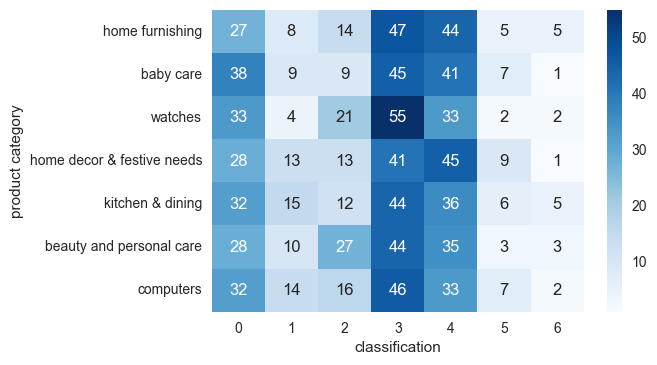

In [87]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel("classification")
plt.ylabel('product category')
plt.show()

## CNN - Transfert Learning

## Transfer Learning

Source : https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

### Pre-Trained Model as Feature Extractor Preprocessor
>The pre-trained model may be used as a standalone program to extract features from new photographs.

>Specifically, the extracted features of a photograph may be a vector of numbers that the model will use to describe the specific features in a photograph. These features can then be used as input in the development of a new model.

>The last few layers of the VGG16 model are fully connected layers prior to the output layer. These layers will provide a complex set of features to describe a given input image and may provide useful input when training a new model for image classification or related computer vision task.

>The image can be loaded and prepared for the model.

>We will load the model with the classifier output part of the model, but manually remove the final output layer. This means that the second last fully connected layer with 4096 nodes will be the new output layer.

>This vector of 4096 numbers will be used to represent the complex features of a given input image that can then be saved to file to be loaded later and used as input to train a new model.

In [89]:
# Creating the model with VGG16() pretained and removing last layers
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16() #Creation of VGG16 model implemented by Keras
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

2022-04-05 15:01:39.326805: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [90]:
# Creation of function to preporcess image and predict features from model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

def preprocess_VGG16(img):
    img = load_img(img, target_size=(224,224)) #VGG16 expects a 224x224 image np.array
    img = np.array(img) 
    img = img.reshape(1,224,224,3) 
    img = preprocess_input(img) #for VGG16
    return img

def model_vgg16(img, model=model):
    features = model.predict(img, use_multiprocessing=True)
    return features

In [95]:
#train['image']
df['path'] = df['image'].apply(lambda x: 'data/Images/'+str(x))

In [96]:
# Features extraction

df['resize_VGG16'] = df['path'].apply(preprocess_VGG16)
df['preprocess_VGG16'] = df['resize_VGG16'].apply(model_vgg16)

/Users/franck/opt/anaconda3/envs/P6_devenv/lib/python3.9/site-packages/PIL/Image.py:3011: DecompressionBombWarning:

Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.



In [97]:
# Evaluation of the shape of the features dataset
vgg16_feat = np.array(df['preprocess_VGG16'].values.tolist())
print('Shape:', vgg16_feat.shape)
vgg16_feat = vgg16_feat.reshape(-1, vgg16_feat.shape[2])
print('Reshape Shape:', vgg16_feat.shape)

Shape: (1050, 1, 4096)
Reshape Shape: (1050, 4096)


Dataset dimensions before PCA:  (1050, 4096)
Dataset dimensions after PCA:  (1050, 803)


/Users/franck/opt/anaconda3/envs/P6_devenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(1050, 3)


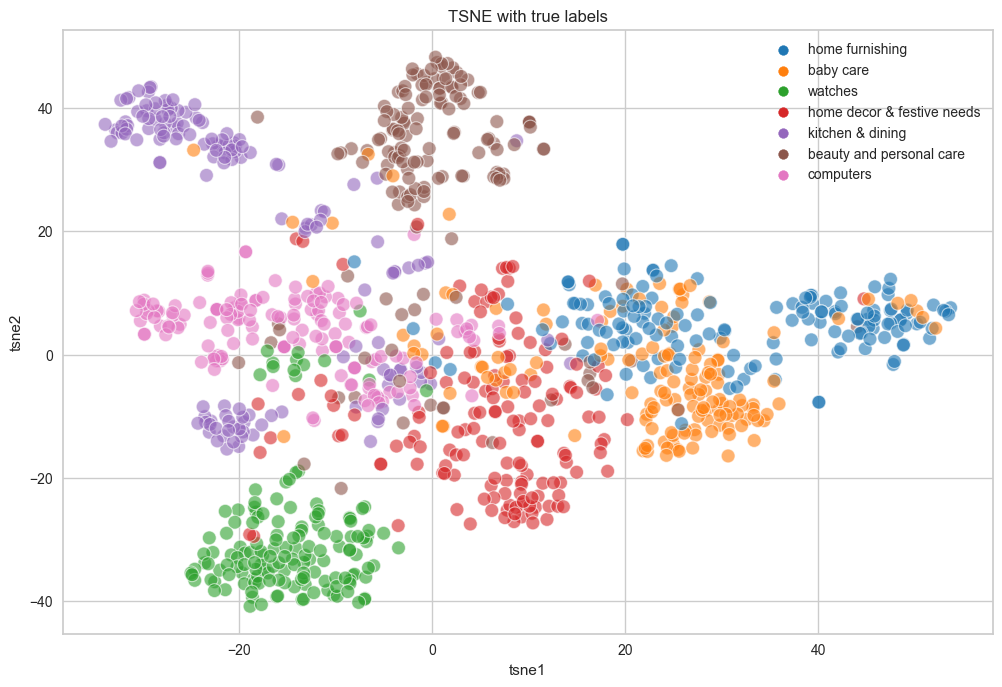

In [98]:
# 2D visusalisation using PCA as dimension reduction and T-SNE as visualisation tool
print("Dataset dimensions before PCA: ", vgg16_feat.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(vgg16_feat)
print("Dataset dimensions after PCA: ", feat_pca.shape)


from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2,
                     perplexity=30, 
                     n_iter=2000,
                     init='random',
                     random_state=6)

X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2],
                       columns=['tsne1', 'tsne2'])

df_tsne['label'] = df['product_category']
print(df_tsne.shape)

plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue="label",
                data=df_tsne,
                legend="brief",
                palette=sns.color_palette('tab10', n_colors=7),
                s=100,
                alpha=0.6)

plt.title('TSNE with true labels')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 

plt.show()

In [99]:
# CLustering 
cls = cluster.KMeans(n_clusters=7,
                     random_state=123)
cls.fit(X_tsne)

df_tsne['cluster'] = cls.labels_
print(df_tsne.shape)

(1050, 4)


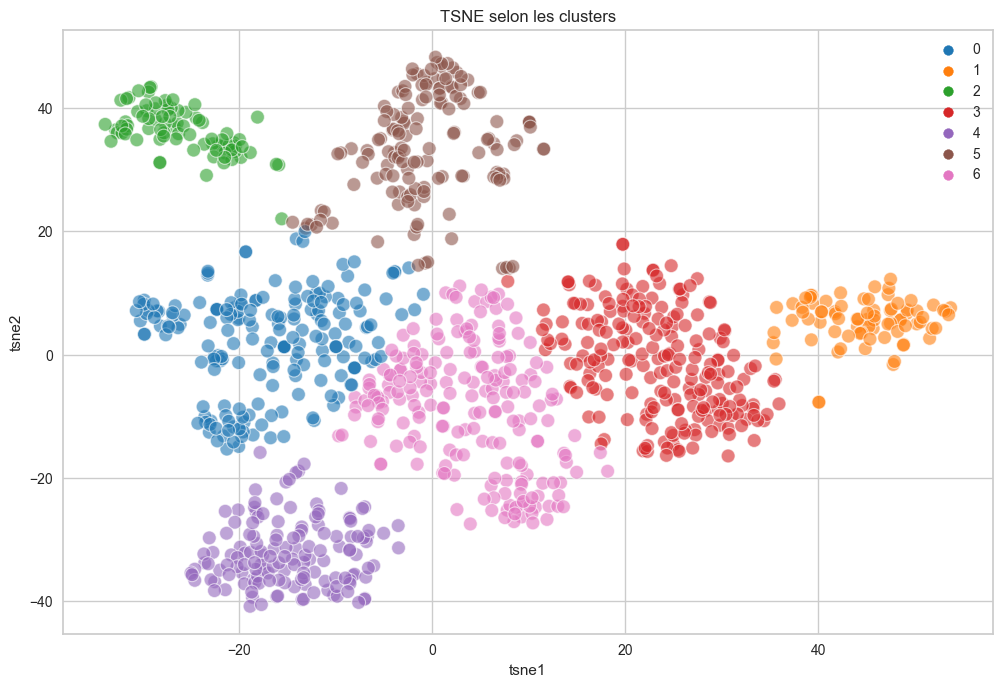

ARI:  0.4781719370309006


In [100]:
# Cluster visualisation

plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue='cluster',
                palette=sns.color_palette('tab10', n_colors=7),
                s=100,
                alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 

plt.show()

labels = df_tsne['label']
print("ARI: ", metrics.adjusted_rand_score(df['label'], cls.labels_))

In [101]:
df['cluster_CNN'] = cls.labels_

In [102]:
df.groupby("cluster_CNN").count()['label']

cluster_CNN
0    191
1     79
2     81
3    214
4    143
5    142
6    200
Name: label, dtype: int64

In [103]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [2, 3, 0, 6, 5, 1, 4]
    print ("Cluster correspondance : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(df['label'], cls.labels_)
conf_mat = metrics.confusion_matrix(df['label'], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df['label'], cls_labels_transform))

Cluster correspondance :  [2 4 5 0 6 1 3]
[[111   5   2  23   8   1   0]
 [  8 117  11  10   1   1   2]
 [  1   1 119  29   0   0   0]
 [ 16   5   9 115   1   0   4]
 [ 76   0   1   4  69   0   0]
 [  2  14  38  17   0  79   0]
 [  0   0  11   2   0   0 137]]

              precision    recall  f1-score   support

           0       0.52      0.74      0.61       150
           1       0.82      0.78      0.80       150
           2       0.62      0.79      0.70       150
           3       0.57      0.77      0.66       150
           4       0.87      0.46      0.60       150
           5       0.98      0.53      0.68       150
           6       0.96      0.91      0.94       150

    accuracy                           0.71      1050
   macro avg       0.76      0.71      0.71      1050
weighted avg       0.76      0.71      0.71      1050



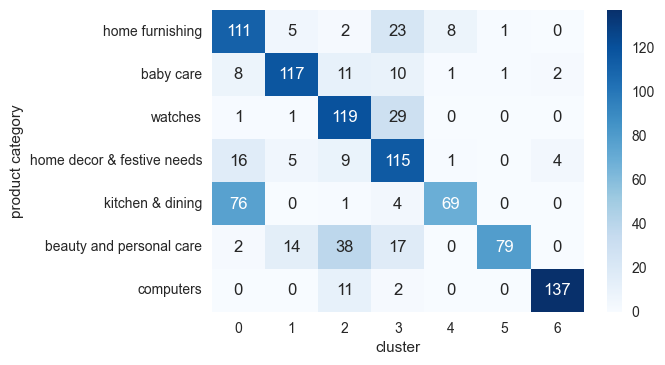

In [104]:
# Clsutering evaluation

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues",  fmt='.0f')
plt.xlabel("cluster")
plt.ylabel('product category')
plt.show()

Use feature extracted from a pretrained VGG16 CNN give results (ARI = 0.44 and Accuracy = 0.65) which go in favor for a classification using image